<a href="https://colab.research.google.com/github/SunshengGu/SYDE522/blob/master/522_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Initialization**

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf # tensorflow
import os
from sklearn.model_selection import train_test_split # split out a validation set form the training set
import matplotlib.pyplot as plt # for visualizing the data
import random

In [3]:
# Input data files are available in the dataset_folder directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
dataset_folder = "drive/My Drive/Kaggle_challenge/data"

print(os.listdir(dataset_folder))

['train_label.npy', 'test_x.npy', 'train_x.npy']


In [4]:
# Read in training data
x_train_init = np.load(dataset_folder + '/train_x.npy')
y_train_init = np.load(dataset_folder + '/train_label.npy')

# Split training data into training set (80%) and validation set (20%) 
X_train, X_val, y_train, y_val = train_test_split(x_train_init, y_train_init, test_size=0.2)

# Read in test data
X_test = np.load(dataset_folder + '/test_x.npy')

# Confirm dimentions of datasets are correct
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)

(608, 168, 308, 3)
(608,)
(152, 168, 308, 3)
(152,)
(200, 168, 308, 3)


In [5]:
# there are 20 categories
labels = np.unique(y_train_init)
labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

# **Data Visualization**


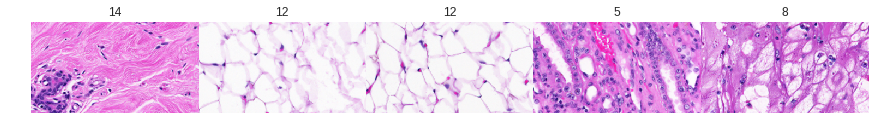

In [6]:
# show 5 random training images
fig, axs = plt.subplots(1,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(5):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[index])

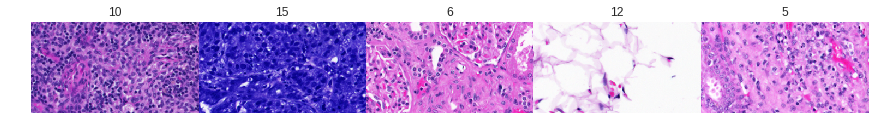

In [7]:
# show 5 random validation images
fig, axs = plt.subplots(1,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(5):
    index = random.randint(0, len(X_val))
    image = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[index])

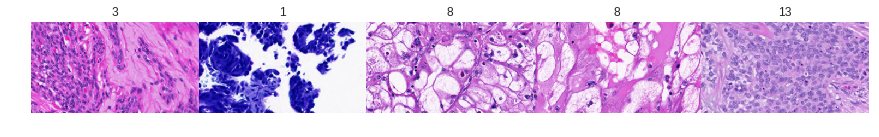

In [8]:
# show 5 random test images
fig, axs = plt.subplots(1,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(5):
    index = random.randint(0, len(X_test))
    image = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[index])

# **Data Pre-processing & Augmentation**

In [0]:
# Enable shuffle, set up TensorFlow, and import OpenCV
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
import cv2

In [0]:
# Normalize the images so that pixel values are between -1 and 1
# Normalization can help optimizing cost function according to:
# https://www.coursera.org/lecture/deep-neural-network/normalizing-inputs-lXv6U
def normalize(img, n=128.0):
    img_float = img.astype(np.float32) # Convert to float
    img_float -= n; # Average = 0
    normal = img_float / n; # Achieve equal variance
    return normal

In [0]:
# Apply random horizontal and verticle flip with 50% probability

def h_flip(img):
  if random.randint(0,1):
    img = cv2.flip(img, 1)
  return img
    
def v_flip(img):
  if random.randint(0,1):
    img = cv2.flip(img, 0)
  return img

In [0]:
'''
This function is modified based on a function from here:

*    Author: <Jeremy Shannon>
*    Date: <Jan 16, 2017>
*    Availability: <https://github.com/jeremy-shannon/CarND-Traffic-Sign-Classifier-Project
     /blob/master/Traffic_Sign_Classifier.ipynb>
'''

# Randomly scale images with 50% probability of returning original image
def scaling(img, limit=30):   
    if not random.randint(0,1):
      return img
    
    rows,cols,_ = img.shape
    aspect_ratio = cols/rows

    # transform limits in y and x directions (in number of pixels)
    # retain the same aspect ratio in the resulting image as well
    py = np.random.randint(-limit,limit)
    px = py * aspect_ratio
    
    # starting locations
    pts1 = np.float32([[py,px],[rows-py,px],[rows-py,cols-px],[py,cols-px]])

    # ending locations (4 corners)
    pts2 = np.float32([[0,0],[rows,0],[rows,cols],[0,cols]])
    
    # perform perspective transform to scale the image
    M = cv2.getPerspectiveTransform(pts1,pts2)
    dst = cv2.warpPerspective(img,M,(cols,rows))
    
    return dst

In [0]:
'''
This function is modified based on a function from here:

*    Author: <Jeremy Shannon>
*    Date: <Jan 16, 2017>
*    Availability: <https://github.com/jeremy-shannon/CarND-Traffic-Sign-Classifier-Project
     /blob/master/Traffic_Sign_Classifier.ipynb>
'''

# Randomly change brightness by +- 20% with 50% probability of returning original image
def brightness_change(img, bright=0.2):
    if not random.randint(0,1):
      return img
    
    shifted = img + 1.0   # shift normalized image to (0,2) range
    img_max_value = max(shifted.flatten())
    max_coef = 1.0 + bright
    min_coef = 1.0 - bright
    coef = np.random.uniform(min_coef, max_coef)
    dst = shifted * coef - 1.0 # shift back to (-1, 1) range
    
    return dst

In [0]:
# Process the training data, generate a training set 3 times larger than the original one
def train_preprocess(img):
  normal = normalize(img)
  
  # Initialize an array to store result images
  results = np.zeros(shape = (3*len(img), 168, 308, 3))
  j = 0
  i = 0
  
  while j < 3:
    # Scaling, and brightness shift
    for image in normal:
      #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      h_flipped = h_flip(image)
      v_flipped = v_flip(h_flipped)
      scaled = scaling(v_flipped)
      results[i] = brightness_change(scaled)
      # results[i] = cv2.cvtColor(brightness_change(scaled), cv2.COLOR_RGB2BGR)
      i+=1
    j+=1
    
  return results

In [0]:
# generate the normalized datasets
# Apply gray scaling and normalization to all 3 sets
X_train_norm = normalize(X_train)
X_val_norm = normalize(X_val)
X_test_norm = normalize(X_test)

In [16]:
print(X_train_norm.shape)

(608, 168, 308, 3)


In [17]:
# apply the whole data augmentation pipeline
X_train_augmented = train_preprocess(X_train)
print(X_train_augmented.shape)

(1824, 168, 308, 3)


In [18]:
# create an augmented training label to match the augmented training input size
y_train_augmented = y_train

for i in range(2):
  y_train_augmented = np.concatenate((y_train_augmented, y_train))
  
print(y_train_augmented.shape)

(1824,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


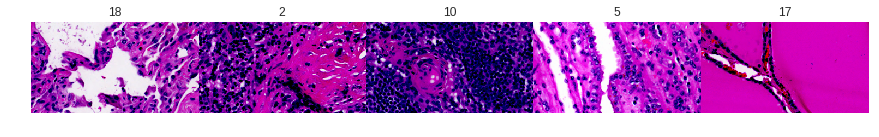

In [19]:
# show first 5 normalized train images
fig, axs = plt.subplots(1,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(5):
    image = X_train_norm[i]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


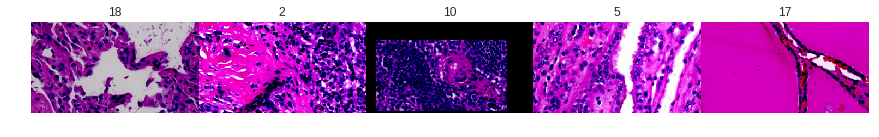

In [20]:
# show first 5 normalized augmented train images
fig, axs = plt.subplots(1,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(5):
    image = X_train_augmented[i]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[i])

# **Training**

In [21]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras import backend as k 
from keras import metrics
from keras import losses
from keras.callbacks import ModelCheckpoint, Callback, LambdaCallback

Using TensorFlow backend.


In [0]:
# Save the model with the lowest validation loss  
checkpoint = ModelCheckpoint("vgg16_0.001_lr.h5",
                             monitor='val_acc', 
                             verbose=1, # showing a moving progress bar
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', # for 'val_acc', automatically 'max'
                             period=1) # number of epochs between checkpoints

In [0]:
'''
VGG16 model modified based on this:
https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3
'''

def VGG_16(weights_path=None):
    model = Sequential()
    # input size adjusted to the image size
    model.add(ZeroPadding2D((1,1),input_shape=(168,308,3)))
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(BatchNormalization())
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, (3, 3), activation="relu"))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation="relu"))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation="relu"))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation="relu"))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation="relu"))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation="relu"))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation="relu"))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    # there are 20 classes
    model.add(Dense(20, activation='linear'))
    
    if weights_path:
        model.load_weights(weights_path)

    return model

In [0]:
# convert labels to one-hot vectors
from keras.utils.np_utils import to_categorical

one_hot_y_train_augmented = to_categorical(y_train_augmented)
one_hot_y_val = to_categorical(y_val)

In [32]:
model = VGG_16()

# use the Adam optimizer
adam = Adam(lr=0.001, epsilon=10e-8)

# build the model
# use categorical cross-entropy as the loss function as this is a multi-class classification problem
# returns training accuracy and validation accuracy
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_14 (ZeroPaddi (None, 170, 310, 3)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 168, 308, 64)      1792      
_________________________________________________________________
batch_normalization_3 (Batch (None, 168, 308, 64)      256       
_________________________________________________________________
zero_padding2d_15 (ZeroPaddi (None, 170, 310, 64)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 168, 308, 64)      36928     
_________________________________________________________________
batch_normalization_4 (Batch (None, 168, 308, 64)      256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 84, 154, 64)       0         
__________

In [0]:
'''
source: https://github.com/keras-team/keras/issues/2548
doesn't work

class ValCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nValidation accuracy: {}, acc: {}\n'.format(acc))
'''

In [34]:
batch_size = 16
epochs = 10

# Train the model using the normalized and augmented training set
history = model.fit(X_train_augmented, one_hot_y_train_augmented, 
          epochs=epochs, batch_size=batch_size, 
          validation_data=(X_val_norm, one_hot_y_val), 
          callbacks = [checkpoint],
          verbose=1, 
          shuffle="True") # shuffle training data before each epoch
          #class_weight = class_weight

Train on 1824 samples, validate on 152 samples
Epoch 1/10
1824/1824 [==============================] - 87s 47ms/step - loss: 8.0076 - acc: 0.0482 - val_loss: 8.9074 - val_acc: 0.0592

Epoch 00001: val_acc improved from -inf to 0.05921, saving model to vgg16_0.001_lr.h5


KeyboardInterrupt: ignored